In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# Data processing.

## Use Taobao Datasets.

In [2]:
class CustomDataset(Dataset):
    """from.pkl"""
    def __init__(self, data):
        self.data = data  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]  
        time_seqs = [event["time_since_start"] for event in sequence]
        time_delta_seqs = [event["time_since_last_event"] for event in sequence]
        type_seqs = [event["type_event"] for event in sequence]

        return {
            'time_seqs': torch.tensor(time_seqs, dtype=torch.float32),
            'time_delta_seqs': torch.tensor(time_delta_seqs, dtype=torch.float32),
            'type_seqs': torch.tensor(type_seqs, dtype=torch.long),
        }

def load_pkl(file_path, split="train"):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data[split] 


def pad_collate_fn(batch):
    max_len = max(len(sample['time_seqs']) for sample in batch)

    padded_time_seqs = torch.zeros(len(batch), max_len, dtype=torch.float32)
    padded_time_delta_seqs = torch.zeros(len(batch), max_len, dtype=torch.float32)
    padded_type_seqs = torch.zeros(len(batch), max_len, dtype=torch.long)

    for i, sample in enumerate(batch):
        seq_len = len(sample['time_seqs'])
        padded_time_seqs[i, :seq_len] = sample['time_seqs']
        padded_time_delta_seqs[i, :seq_len] = sample['time_delta_seqs']
        padded_type_seqs[i, :seq_len] = sample['type_seqs']

    return {
        'time_seqs': padded_time_seqs,
        'time_delta_seqs': padded_time_delta_seqs,
        'type_seqs': padded_type_seqs,
    }

def create_data_loader(file_path, batch_size, split="train", shuffle=True):
    data = load_pkl(file_path, split)
    dataset = CustomDataset(data)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=pad_collate_fn)
    return data_loader

train_file = "./train.pkl"
test_file = "./test.pkl"
dev_file = "./dev.pkl"

batch_size = 32

train_loader = create_data_loader(train_file, batch_size, split="train", shuffle=True)
test_loader = create_data_loader(test_file, batch_size, split="test", shuffle=False)
dev_loader = create_data_loader(dev_file, batch_size, split="dev", shuffle=False)

def get_dataset_stats(dataloader):
    all_types = set() 
    min_delta_t = float('inf')
    max_delta_t = float('-inf') 

    for batch in dataloader:
        type_seqs = batch['type_seqs']
        for seq in type_seqs:
            all_types.update(seq.tolist())

        time_delta_seqs = batch['time_delta_seqs']
        min_delta_t = min(min_delta_t, torch.min(time_delta_seqs).item())
        max_delta_t = max(max_delta_t, torch.max(time_delta_seqs).item())

    num_event_types = len(all_types)
    return num_event_types, (min_delta_t, max_delta_t)

#Statisticals
num_event_types, delta_t_range = get_dataset_stats(train_loader)
print(f"num_event_types: {num_event_types}")
print(f"delta_t_range: {delta_t_range}")

num_event_types: 17
delta_t_range: (0.0, 1.9997999668121338)


# Model Design.

## Generator.

In [3]:
class RMTPPGenerator(nn.Module):
    def __init__(self, model_config):
        super(RMTPPGenerator, self).__init__()
        self.hidden_size = model_config.hidden_size
        self.num_event_types = model_config.num_event_types

        self.layer_rnn = nn.RNN(input_size=self.hidden_size, 
                               hidden_size=self.hidden_size,
                               num_layers=1, 
                               batch_first=True)
        self.hidden_to_event_logits = nn.Linear(self.hidden_size, self.num_event_types)
        self.layer_temporal_emb = nn.Linear(1, self.hidden_size)
        self.layer_type_emb = nn.Embedding(self.num_event_types, self.hidden_size)

        self.hidden_to_intensity_logits = nn.Linear(self.hidden_size, 1)
        self.b_t = nn.Parameter(torch.zeros(1, 1))
        self.w_t = nn.Parameter(torch.zeros(1, 1))
        nn.init.xavier_normal_(self.b_t)
        nn.init.xavier_normal_(self.w_t)

    def forward(self, init_event, max_len, num_samples=100):
        event_type, delta_t = init_event
        if not isinstance(event_type, torch.Tensor):
            event_type = torch.tensor(event_type)
        if not isinstance(delta_t, torch.Tensor):
            delta_t = torch.tensor(delta_t, dtype=torch.float32)
        
        hidden_state = torch.zeros(1, 1, self.hidden_size)

        generated_sequence = {
            'type_seqs': [],
            'time_delta_seqs': [],
            'time_seqs': []
        }

        current_time = 0.0

        for _ in range(max_len):
            type_emb = self.layer_type_emb(event_type).unsqueeze(0) 
            time_emb = self.layer_temporal_emb(delta_t.view(1, 1))  
            combined_emb = (type_emb + time_emb).unsqueeze(0)
            output, hidden_state = self.layer_rnn(combined_emb, hidden_state)
            
            # event type generation
            event_logits = self.hidden_to_event_logits(output.squeeze(0))  # [1, num_event_types]
            event_type = torch.multinomial(event_logits.softmax(dim=-1), num_samples=1).squeeze()
            
            # time generation
            base_times = torch.linspace(0, 1, num_samples // 3)
            small_dts = 0.001 + base_times ** 2 * 0.4 
            medium_dts = 0.5 + base_times ** 1.2 * 0.6
            large_dts = 1.1 + base_times ** 1.5 * 0.5
            sampled_dts = torch.cat([small_dts, medium_dts, large_dts]).view(-1, 1)
            sampled_dts, _ = torch.sort(sampled_dts)
            hidden_influence = self.hidden_to_intensity_logits(output.squeeze(0))
            intensity_logits = hidden_influence + self.w_t * sampled_dts + self.b_t
            lambdas = torch.exp(intensity_logits.clamp(max=math.log(1e2), min=math.log(1e-2)))
            delta_t_steps = sampled_dts[1:] - sampled_dts[:-1]
            avg_lambdas = (lambdas[1:] + lambdas[:-1]) / 2
            cdf = torch.cumsum(avg_lambdas.squeeze(-1) * delta_t_steps.squeeze(-1), dim=0)
            cdf = torch.cat([torch.zeros(1), cdf]) 
            U = torch.rand(1) ** 1.5 
            target_intensity = -torch.log(1 - U)
            delta_t_idx = torch.searchsorted(cdf, target_intensity)
            delta_t_idx = torch.clamp(delta_t_idx, max=len(sampled_dts) - 1)
            delta_t = sampled_dts[delta_t_idx].squeeze()

            small_noise = torch.randn(1) * 0.01 * delta_t
            delta_t = torch.clamp(delta_t + small_noise, min=1e-3)
            current_time += delta_t.item()

            generated_sequence['type_seqs'].append(event_type.item())
            generated_sequence['time_delta_seqs'].append(delta_t.item())
            generated_sequence['time_seqs'].append(current_time)

        return generated_sequence

## Discriminator.

In [4]:
class RMTPPDiscriminator(nn.Module):
    def __init__(self, model_config):
        super(RMTPPDiscriminator, self).__init__()
        self.hidden_size = model_config.hidden_size
        self.layer_rnn = nn.RNN(input_size=self.hidden_size, 
                               hidden_size=self.hidden_size,
                               num_layers=1, 
                               batch_first=True)
        self.hidden_to_binary = nn.Linear(self.hidden_size, 1)
        self.layer_temporal_emb = nn.Linear(1, self.hidden_size)
        self.layer_type_emb = nn.Embedding(model_config.num_event_types, self.hidden_size)

    def forward(self, sequences):
        type_seqs = sequences['type_seqs']
        time_delta_seqs = sequences['time_delta_seqs']
        
        hidden_state = torch.zeros(1, 1, self.hidden_size)
        
        seq_length = len(type_seqs)
        combined_inputs = []
        
        for i in range(seq_length):
            event_type = torch.tensor(type_seqs[i])
            delta_t = torch.tensor(time_delta_seqs[i], dtype=torch.float32)
            
            type_emb = self.layer_type_emb(event_type)
            time_emb = self.layer_temporal_emb(delta_t.view(1))
            combined_emb = type_emb + time_emb
            combined_inputs.append(combined_emb)
        
        combined_inputs = torch.stack(combined_inputs).unsqueeze(0)
        
        _, hidden_state = self.layer_rnn(combined_inputs, hidden_state)
        
        real_or_fake = self.hidden_to_binary(hidden_state.squeeze(0))
        return torch.sigmoid(real_or_fake.squeeze(0))

# Training.

## Model config.

In [5]:
class ModelConfig:
    def __init__(self, hidden_size, num_event_types):
        self.hidden_size = hidden_size
        self.num_event_types = num_event_types

model_config = ModelConfig(hidden_size=368, num_event_types=17)

generator = RMTPPGenerator(model_config)
discriminator = RMTPPDiscriminator(model_config)

generator_optimizer = optim.Adam(generator.parameters(), lr=0.001)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.05)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=3e-4, betas=(0.5, 0.999))

num_epochs = 10

## Define Train Process.

In [ ]:
def train_gan(generator, discriminator, real_batch, generator_optimizer, discriminator_optimizer, max_len):

    real_label = torch.full((real_batch['type_seqs'].size(0),), 0.95)
    fake_label = torch.full((real_batch['type_seqs'].size(0),), 0.05)

    discriminator_optimizer.zero_grad()
    total_d_loss = 0
    
    for i in range(real_batch['time_seqs'].size(0)):
        real_sequence = {
            'time_seqs': real_batch['time_seqs'][i].tolist(),
            'time_delta_seqs': real_batch['time_delta_seqs'][i].tolist(),
            'type_seqs': real_batch['type_seqs'][i].tolist()
        }

        init_event = (
            torch.tensor(real_sequence['type_seqs'][0]),
            torch.tensor(real_sequence['time_delta_seqs'][0], dtype=torch.float32)
        )

        with torch.no_grad():
            generated_sequence = generator(init_event, max_len)

        real_score = discriminator(real_sequence)
        fake_score = discriminator(generated_sequence)

        d_real_loss = F.binary_cross_entropy(real_score, real_label[i].unsqueeze(0))
        d_fake_loss = F.binary_cross_entropy(fake_score, fake_label[i].unsqueeze(0))
        d_loss = d_real_loss + d_fake_loss
        total_d_loss += d_loss

    total_d_loss /= real_batch['time_seqs'].size(0) 
    total_d_loss.backward()
    discriminator_optimizer.step()

    generator_optimizer.zero_grad()
    total_g_loss = 0

    for i in range(real_batch['time_seqs'].size(0)):
        real_sequence = {
            'time_seqs': real_batch['time_seqs'][i].tolist(),
            'time_delta_seqs': real_batch['time_delta_seqs'][i].tolist(),
            'type_seqs': real_batch['type_seqs'][i].tolist()
        }

        init_event = (
            torch.tensor(real_sequence['type_seqs'][0]),
            torch.tensor(real_sequence['time_delta_seqs'][0], dtype=torch.float32)
        )

        generated_sequence = generator(init_event, max_len)

        fake_score = discriminator(generated_sequence)
        g_loss = F.binary_cross_entropy(fake_score, real_label[i].unsqueeze(0))
        total_g_loss += g_loss

    total_g_loss /= real_batch['time_seqs'].size(0)  
    total_g_loss.backward()  
    generator_optimizer.step() 

    return total_d_loss.item(), total_g_loss.item()

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_idx, real_batch in enumerate(train_loader):
        max_len = real_batch['time_seqs'].size(1) 
        d_loss, g_loss = train_gan(
            generator, discriminator, real_batch,
            generator_optimizer, discriminator_optimizer, max_len
        )
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx + 1}: D_loss = {d_loss:.4f}, G_loss = {g_loss:.4f}")

torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

Epoch 1/10
Batch 10: D_loss = 0.9069, G_loss = 1.0351
Batch 20: D_loss = 0.6658, G_loss = 1.6089
Batch 30: D_loss = 0.5272, G_loss = 2.0938
Batch 40: D_loss = 0.5048, G_loss = 2.0448
Epoch 2/10
Batch 10: D_loss = 0.4999, G_loss = 2.2707
Batch 20: D_loss = 0.5724, G_loss = 2.3835
Batch 30: D_loss = 0.5260, G_loss = 2.5933
Batch 40: D_loss = 0.5230, G_loss = 2.3750
Epoch 3/10
Batch 10: D_loss = 0.5427, G_loss = 2.5709
Batch 20: D_loss = 0.5646, G_loss = 2.3312
Batch 30: D_loss = 0.5095, G_loss = 2.3865
Batch 40: D_loss = 0.5246, G_loss = 2.3551
Epoch 4/10
Batch 10: D_loss = 0.5327, G_loss = 2.5864
Batch 20: D_loss = 0.7429, G_loss = 2.6856
Batch 30: D_loss = 0.4602, G_loss = 2.6037
Batch 40: D_loss = 0.4647, G_loss = 2.4370
Epoch 5/10
Batch 10: D_loss = 0.7486, G_loss = 2.6984
Batch 20: D_loss = 0.4349, G_loss = 2.5880
Batch 30: D_loss = 0.5501, G_loss = 2.6990
Batch 40: D_loss = 0.4928, G_loss = 2.8907
Epoch 6/10
Batch 10: D_loss = 0.4603, G_loss = 2.5442
Batch 20: D_loss = 0.4424, G_lo

# Plot the Generated Process.

In [6]:
generator_1 = RMTPPGenerator(model_config)
discriminator_1 = RMTPPDiscriminator(model_config)

generator_1.load_state_dict(torch.load("generator.pth"))
discriminator_1.load_state_dict(torch.load("discriminator.pth"))

generator.eval()
discriminator.eval()

C:\Users\14857\AppData\Local\Temp\ipykernel_15856\327164852.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_1.load_state_dict(torch.load("generator.pth"))
C:\U

RMTPPDiscriminator(
  (layer_rnn): RNN(368, 368, batch_first=True)
  (hidden_to_binary): Linear(in_features=368, out_features=1, bias=True)
  (layer_temporal_emb): Linear(in_features=1, out_features=368, bias=True)
  (layer_type_emb): Embedding(17, 368)
)

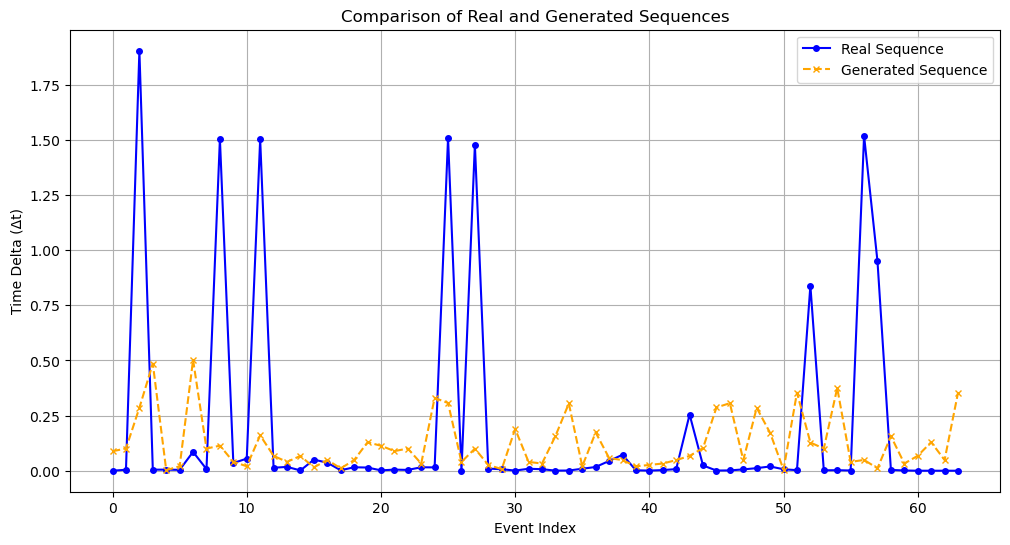

{'type_seqs': [4, 10, 11, 11, 7, 16, 0, 0, 9, 2, 12, 4, 16, 14, 12, 13, 4, 0, 5, 3, 6, 1, 1, 2, 3, 13, 10, 8, 15, 5, 15, 1, 7, 13, 10, 16, 4, 9, 0, 9, 8, 1, 12, 6, 10, 16, 8, 11, 13, 2, 5, 3, 7, 2, 0, 10, 11, 15, 12, 10, 9, 2, 2, 3], 'time_delta_seqs': [0.08852904289960861, 0.10060150176286697, 0.28548115491867065, 0.4858715236186981, 0.002551331417635083, 0.020133789628744125, 0.5022050142288208, 0.10041659325361252, 0.11361534893512726, 0.04043027386069298, 0.020266452804207802, 0.16037970781326294, 0.06742715835571289, 0.04018731787800789, 0.06712646037340164, 0.015072079375386238, 0.04893588647246361, 0.010758492164313793, 0.04809156060218811, 0.12882015109062195, 0.11341860890388489, 0.08891905844211578, 0.10056500136852264, 0.032543689012527466, 0.33041924238204956, 0.3069086968898773, 0.039733756333589554, 0.10017519444227219, 0.026197047904133797, 0.007241410203278065, 0.18944458663463593, 0.03993692621588707, 0.03263872489333153, 0.15692517161369324, 0.30491045117378235, 0.020

In [22]:
def plot_sequences(real_sequence, generated_sequence, title):
    real_delta = real_sequence['time_delta_seqs']
    gen_delta = generated_sequence['time_delta_seqs']

    real_idx = list(range(len(real_delta)))
    gen_idx = list(range(len(gen_delta)))

    plt.figure(figsize=(12, 6))
    plt.plot(real_idx, real_delta, 'o-', label="Real Sequence", color='blue', markersize=4)
    plt.plot(gen_idx, gen_delta, 'x--', label="Generated Sequence", color='orange', markersize=4)
    plt.xlabel("Event Index")
    plt.ylabel("Time Delta (Δt)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

for batch_idx, real_batch in enumerate(train_loader):
        real_sequences = []
        for i in range(real_batch['time_seqs'].size(0)):
            real_sequences.append({
                'time_seqs': real_batch['time_seqs'][i].tolist(),
                'time_delta_seqs': real_batch['time_delta_seqs'][i].tolist(),
                'type_seqs': real_batch['type_seqs'][i].tolist()
            })
            break

real_sequence = real_sequences[0]
generated_sequence = generator(
    (torch.tensor(real_sequence['type_seqs'][0]), torch.tensor(real_sequence['time_delta_seqs'][0])), max_len=len(real_sequence['type_seqs'])
)
plot_sequences(real_sequence, generated_sequence, "Comparison of Real and Generated Sequences")
print(generated_sequence)

# Transfer Learning, from GAN to Predictor.

## Define the predictor.

In [ ]:
class RMTPPPredictorStepwise(nn.Module):
    def __init__(self, generator):
        super(RMTPPPredictorStepwise, self).__init__()

        self.hidden_size = generator.hidden_size
        self.num_event_types = generator.num_event_types

        self.layer_rnn = generator.layer_rnn
        self.hidden_to_event_logits = generator.hidden_to_event_logits
        self.layer_temporal_emb = generator.layer_temporal_emb
        self.layer_type_emb = generator.layer_type_emb
        self.hidden_to_intensity_logits = generator.hidden_to_intensity_logits
        self.b_t = generator.b_t
        self.w_t = generator.w_t

        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_event_types)  
        )

        for param in [
            *self.layer_rnn.parameters(),
            *self.hidden_to_event_logits.parameters(),
            *self.layer_temporal_emb.parameters(),
            *self.layer_type_emb.parameters(),
            *self.hidden_to_intensity_logits.parameters(),
            self.b_t,
            self.w_t
        ]:
            param.requires_grad = False

    def forward(self, real_sequence, max_len=38, num_samples=1000):

        type_seqs = real_sequence['type_seqs']
        time_delta_seqs = real_sequence['time_delta_seqs']

        batch_size = type_seqs.size(0)
        hidden_states = []
        hidden_state = torch.zeros(1, batch_size, self.hidden_size)

        hidden_states.append(hidden_state.squeeze(0)) 
        for t in range(type_seqs.size(1)):
            type_emb = self.layer_type_emb(type_seqs[:, t])  
            time_emb = self.layer_temporal_emb(time_delta_seqs[:, t].view(-1, 1))  
            combined_emb = (type_emb + time_emb).unsqueeze(1)  
            _, hidden_state = self.layer_rnn(combined_emb, hidden_state)
            hidden_states.append(hidden_state.squeeze(0))  

        hidden_states = torch.stack(hidden_states, dim=1) 

        current_time = torch.zeros(batch_size)
        predicted_sequence = {
            'type_seqs': [type_seqs[:, 0]],  
            'time_delta_seqs': [time_delta_seqs[:, 0]], 
            'time_seqs': [time_delta_seqs[:, 0]]  
        }
        first_logits = torch.zeros(batch_size, self.num_event_types)
        first_logits.scatter_(1, type_seqs[:, 0].unsqueeze(1), 1) 
        logits = [first_logits]
        
        for t in range(1, max_len):
            current_hidden_state = hidden_states[:, t] if t < hidden_states.size(1) else hidden_state.squeeze(0)

            logit = self.classifier(current_hidden_state) 
            logits.append(logit)
            event_type = torch.multinomial(logit.softmax(dim=-1), num_samples=1).squeeze(-1)

            base_times = torch.linspace(0, 1, num_samples // 3)
            small_dts = 0.001 + base_times ** 2 * 0.4
            medium_dts = 0.5 + base_times ** 1.2 * 0.6  
            large_dts = 1.1 + base_times ** 1.5 * 0.5 
            sampled_dts = torch.cat([small_dts, medium_dts, large_dts]).view(-1, 1)
            sampled_dts, _ = torch.sort(sampled_dts)
            hidden_influence = self.hidden_to_intensity_logits(current_hidden_state)
            intensity_logits = hidden_influence + self.w_t * sampled_dts + self.b_t
            lambdas = torch.exp(intensity_logits.clamp(max=math.log(1e2), min=math.log(1e-2)))
            delta_t_steps = sampled_dts[1:] - sampled_dts[:-1]
            avg_lambdas = (lambdas[1:] + lambdas[:-1]) / 2
            cdf = torch.cumsum(avg_lambdas.squeeze(-1) * delta_t_steps.squeeze(-1), dim=0)
            cdf = torch.cat([torch.zeros(1), cdf])
            U = torch.rand(1) ** 1.5 
            target_intensity = -torch.log(1 - U)
            delta_t_idx = torch.searchsorted(cdf, target_intensity)
            delta_t_idx = torch.clamp(delta_t_idx, max=len(sampled_dts) - 1)
            delta_t = sampled_dts[delta_t_idx].squeeze()

            small_noise = torch.randn(1) * 0.01 * delta_t
            delta_t = torch.clamp(delta_t + small_noise, min=1e-3)
            current_time += delta_t.item()

            predicted_sequence['type_seqs'].append(event_type)
            predicted_sequence['time_delta_seqs'].append(delta_t.view(-1))
            predicted_sequence['time_seqs'].append(current_time)

        for key in predicted_sequence.keys():
            predicted_sequence[key] = torch.stack(predicted_sequence[key], dim=1) 
        logits = torch.stack(logits, dim=1) 

        return predicted_sequence, logits

## Train the Event Type predictor.

In [ ]:
def train_classifier(predictor, train_loader, optimizer, num_epochs=10):

    criterion = nn.CrossEntropyLoss()
    predictor.train()

    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch in train_loader:
            real_type_seqs = batch['type_seqs']
            real_time_delta_seqs = batch['time_delta_seqs']  

            for i in range(real_type_seqs.size(0)): 
                single_sequence = {
                    'type_seqs': real_type_seqs[i].unsqueeze(0), 
                    'time_delta_seqs': real_time_delta_seqs[i].unsqueeze(0)
                }

                optimizer.zero_grad()
                _, logits = predictor(single_sequence, max_len=single_sequence['type_seqs'].size(1))

                loss = criterion(
                    logits.view(-1, logits.size(-1)),
                    single_sequence['type_seqs'][:, :logits.size(1)].reshape(-1)
                )
                loss.backward()
                optimizer.step()

                predictions = logits.argmax(dim=-1)
                correct = (predictions == single_sequence['type_seqs'][:, :logits.size(1)]).sum().item()
                total_correct += correct
                total_samples += single_sequence['type_seqs'][:, :logits.size(1)].numel()
                total_loss += loss.item()

        accuracy = total_correct / total_samples
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")


In [25]:
generator = RMTPPGenerator(model_config)
generator.load_state_dict(torch.load("generator.pth"))
predictor = RMTPPPredictorStepwise(generator)
optimizer = torch.optim.Adam(predictor.classifier.parameters(), lr=1e-3)

C:\Users\14857\AppData\Local\Temp\ipykernel_4800\3836235602.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator.pth"))


In [26]:
train_classifier(predictor, train_loader, optimizer, num_epochs=10)
torch.save(predictor.state_dict(), "predictor.pth")

Epoch 1/10, Loss: 1899.5191, Accuracy: 0.6226
Epoch 2/10, Loss: 1843.0933, Accuracy: 0.6293
Epoch 3/10, Loss: 1832.7723, Accuracy: 0.6301
Epoch 4/10, Loss: 1824.5736, Accuracy: 0.6315
Epoch 5/10, Loss: 1819.6167, Accuracy: 0.6309
Epoch 6/10, Loss: 1817.2061, Accuracy: 0.6320
Epoch 7/10, Loss: 1813.0289, Accuracy: 0.6325
Epoch 8/10, Loss: 1806.9026, Accuracy: 0.6334
Epoch 9/10, Loss: 1805.4380, Accuracy: 0.6333
Epoch 10/10, Loss: 1799.5251, Accuracy: 0.6345


# Test the Effect and Evaluate the performance.

In [27]:
predictor.load_state_dict(torch.load("predictor.pth"))

C:\Users\14857\AppData\Local\Temp\ipykernel_4800\3328229503.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.load_state_dict(torch.load("predictor.pth"))


<All keys matched successfully>

C:\Users\14857\AppData\Local\Temp\ipykernel_4800\2378115919.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_type_seqs = torch.tensor(batch['type_seqs'])
C:\Users\14857\AppData\Local\Temp\ipykernel_4800\2378115919.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])


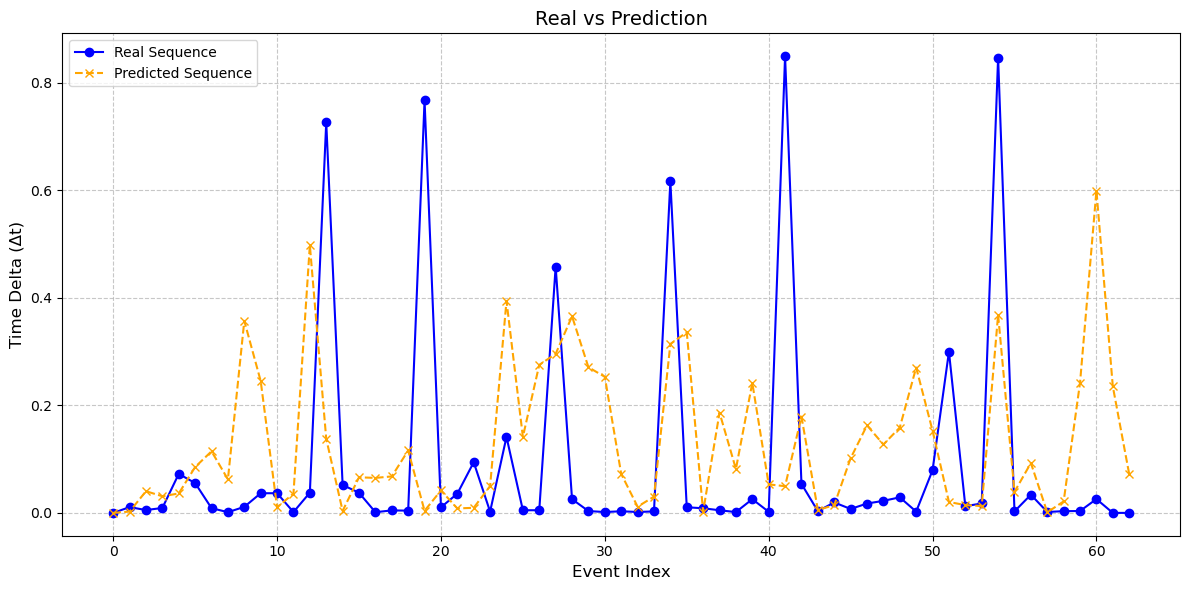

In [28]:
def plot_sequences(real_sequence, generated_sequence, title="Real vs Prediction"):
    real_delta = real_sequence['time_delta_seqs'].squeeze(0)
    gen_delta = generated_sequence['time_delta_seqs'].squeeze(0)

    real_idx = list(range(63))

    plt.figure(figsize=(12, 6))
    plt.plot(real_idx, real_delta, 'o-', label="Real Sequence", color='blue', markersize=6)
    plt.plot(real_idx, gen_delta, 'x--', label="Predicted Sequence", color='orange', markersize=6)
    plt.xlabel("Event Index", fontsize=12)
    plt.ylabel("Time Delta (Δt)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()
    
with torch.no_grad():
        for batch in test_loader:
            real_type_seqs = torch.tensor(batch['type_seqs']) 
            real_time_delta_seqs = torch.tensor(batch['time_delta_seqs']) 

            batch_size, seq_len = real_type_seqs.shape

            for i in range(3,batch_size):
                single_sequence = {
                    'type_seqs': real_type_seqs[i].unsqueeze(0),
                    'time_delta_seqs': real_time_delta_seqs[i].unsqueeze(0) 
                }
                predicted_sequence,_ = predictor(single_sequence, max_len=seq_len)
                break
plot_sequences(single_sequence, predicted_sequence)

In [29]:
def evaluate_model(predictor, test_loader):
    """
    Evaluate acc and RMSE
    Args:
        predictor
        test_loader
    Returns:
        accuracy
        rmse
    """
    total_correct = 0
    total_events = 0
    total_squared_error = 0
    total_time_steps = 0

    predictor.eval()
    with torch.no_grad():
        for batch in test_loader:
            real_type_seqs = torch.tensor(batch['type_seqs']) 
            real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])  

            batch_size, seq_len = real_type_seqs.shape

            for i in range(batch_size):
                single_sequence = {
                    'type_seqs': real_type_seqs[i].unsqueeze(0), 
                    'time_delta_seqs': real_time_delta_seqs[i].unsqueeze(0)
                }
                predicted_sequence,_ = predictor(single_sequence, max_len=seq_len)

                predicted_type_seqs = predicted_sequence['type_seqs'].squeeze(0)
                predicted_time_delta_seqs = predicted_sequence['time_delta_seqs'].squeeze(0)

                correct_predictions = (predicted_type_seqs == real_type_seqs[i]).sum().item()
                total_correct += correct_predictions
                total_events += seq_len

                squared_error = ((predicted_time_delta_seqs - real_time_delta_seqs[i]) ** 2).sum().item()
                total_squared_error += squared_error
                total_time_steps += seq_len

    accuracy = total_correct / total_events
    rmse = math.sqrt(total_squared_error / total_time_steps)

    return accuracy, rmse

accuracy, rmse = evaluate_model(predictor, test_loader)
print(f"Event Type Accuracy: {accuracy:.4f}")
print(f"Time Delta RMSE: {rmse:.4f}")

C:\Users\14857\AppData\Local\Temp\ipykernel_4800\3536195553.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_type_seqs = torch.tensor(batch['type_seqs'])
C:\Users\14857\AppData\Local\Temp\ipykernel_4800\3536195553.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_time_delta_seqs = torch.tensor(batch['time_delta_seqs'])


Event Type Accuracy: 0.5168
Time Delta RMSE: 0.2077
